/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


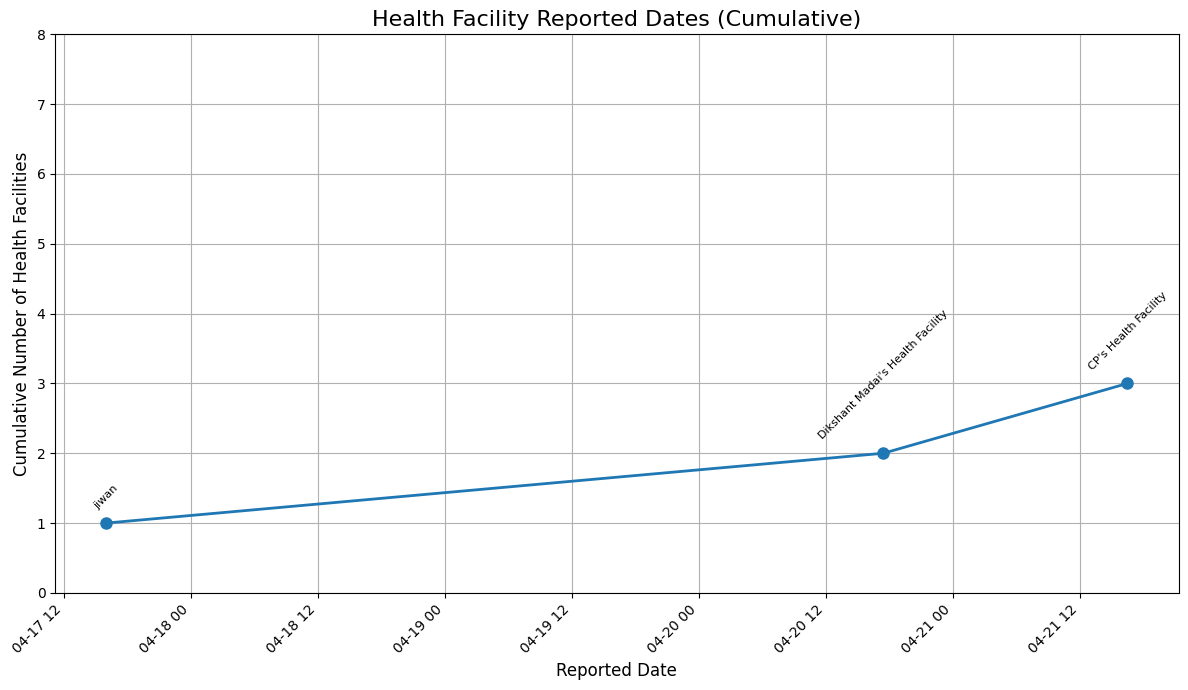

In [2]:
import requests
from requests.auth import HTTPBasicAuth
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

# Use HTTPS for the URL
url = 'https://localhost/medic/_all_docs?include_docs=true'
username = 'medic'
password = 'password'  # Replace with correct CouchDB credentials

# Make the request with SSL verification disabled
response = requests.get(url, auth=HTTPBasicAuth(username, password), verify=False)

if response.status_code == 200:
    try:
        data = response.json()
        district_hospitals = []

        for row in data.get('rows', []):
            doc = row.get('doc', {})
            if doc.get('type') == 'district_hospital':
                district_hospitals.append(doc)

        # Collect the health facility names and their reported dates
        names = []
        reported_dates = []

        for hospital in district_hospitals:
            # Convert the reported date from milliseconds to readable format
            timestamp = hospital.get('reported_date')
            if timestamp:
                readable_date = datetime.fromtimestamp(int(timestamp) / 1000)
                names.append(hospital.get('name'))
                reported_dates.append(readable_date)
            else:
                names.append(hospital.get('name'))
                reported_dates.append(None)

        # Create a DataFrame to make it easy to manipulate and plot
        df = pd.DataFrame({
            'Name': names,
            'Reported Date': reported_dates
        })

        # Drop any rows where Reported Date is None
        df = df.dropna(subset=['Reported Date'])

        # Group by Date and count occurrences (number of health facilities reported on each day)
        df_grouped = df.groupby('Reported Date').size()

        # For cumulative totals: increment the previous value whenever new reports are added
        df_grouped_cumsum = df_grouped.cumsum()

        # Plot
        plt.figure(figsize=(12, 7))
        ax = df_grouped_cumsum.plot(kind='line', marker='o', markersize=8, linewidth=2)

        # Annotate each point with the health facility names
        for i, (reported_date, name) in enumerate(zip(df['Reported Date'], df['Name'])):
            plt.annotate(
                name,
                (reported_date, df_grouped_cumsum.loc[reported_date]),
                textcoords="offset points",
                xytext=(0,10),  # Adjust text position above the marker
                ha='center',
                fontsize=8,
                rotation=45
            )

        # Customize title and labels
        plt.title('Health Facility Reported Dates (Cumulative)', fontsize=16)
        plt.xlabel('Reported Date', fontsize=12)
        plt.ylabel('Cumulative Number of Health Facilities', fontsize=12)

        # Change Y-axis limits if needed
        ax.set_ylim(0, df_grouped_cumsum.max() + 5)

        # Rotate X-axis labels
        plt.xticks(rotation=45)

        # Add grid
        plt.grid(True)

        # Layout adjustment
        plt.tight_layout()

        # Show plot
        plt.show()

    except ValueError:
        print("Response is not valid JSON. Response text:", response.text)
else:
    print(f"Failed to fetch data: {response.status_code} {response.text}")
